<a href="https://colab.research.google.com/github/iammuhammad41/Sentiment-Classification/blob/main/sentiment-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import pickle
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


plt.style.use('ggplot')
sns.set(style='whitegrid')

In [2]:
# Load datasets
train_data = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/train.csv', encoding='latin1')
test_data = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/test.csv', encoding='latin1')

# Display basic information
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Preview the first few rows of the training data
print("\nFirst 5 rows of training data:")
display(train_data.head())

In [3]:
print("\nMissing values in training data:")
print(train_data.isnull().sum())

print("\nMissing values in test data:")
print(test_data.isnull().sum())

In [4]:
# Sentiment distribution in training data
print("\nSentiment distribution in training data:")
print(train_data['sentiment'].value_counts())

In [5]:
# plt.figure(figsize=(10, 6))
# sns.countplot(x='sentiment', data=train_data)
# plt.title('Sentiment Distribution in Training Data')
# plt.show()

In [ ]:
train_data['text'] = train_data['text'].astype(str)
test_data['text'] = test_data['text'].astype(str)

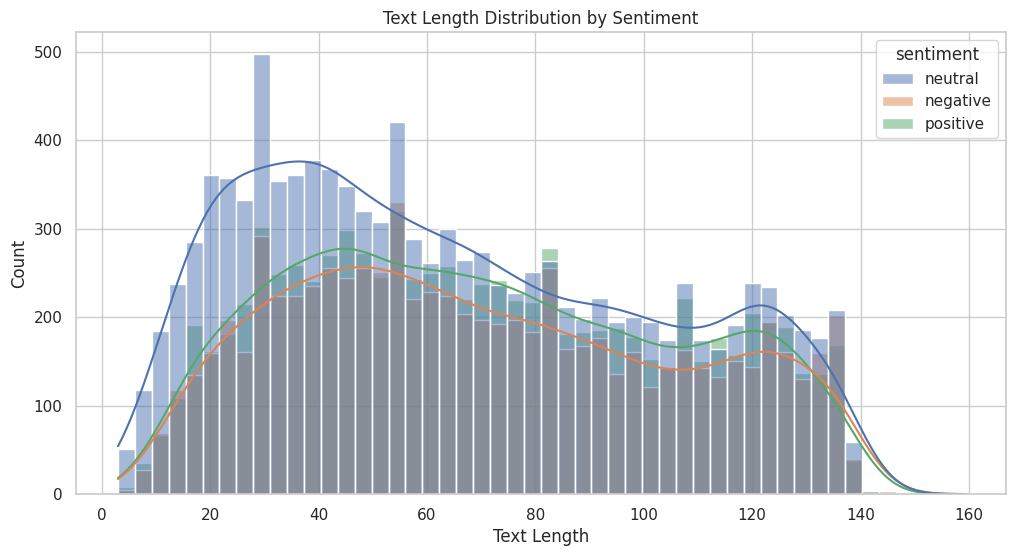

In [ ]:
train_data['text_length'] = train_data['text'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(data=train_data, x='text_length', hue='sentiment', bins=50, kde=True)
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Text Length')
plt.show()


In [ ]:
def clean_text(text):
    """
    Clean and preprocess text data.

    Args:
        text (str): Input text

    Returns:
        str: Cleaned text
    """
    if pd.isna(text):
        return ""


    text = text.lower()


    text = re.sub(r'https?://\S+|www\.\S+', '', text)


    text = re.sub(r'<.*?>', '', text)


    text = re.sub(r'@\w+', '', text)


    text = re.sub(r'#(\w+)', r'\1', text)


    text = text.translate(str.maketrans('', '', string.punctuation))


    text = re.sub(r'\d+', '', text)

    text = re.sub(r'\s+', ' ', text).strip()

    return text

def preprocess_text(text):
    """
    Full preprocessing pipeline: clean, tokenize, remove stopwords, and lemmatize.

    Args:
        text (str): Input text

    Returns:
        str: Preprocessed text
    """
    if pd.isna(text):
        return ""


    text = clean_text(text)


    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    processed_text = ' '.join(tokens)

    return processed_text

In [6]:
print("Preprocessing training data (this may take a few minutes)...")
train_data['processed_text'] = train_data['text'].apply(preprocess_text)

print("Preprocessing test data (this may take a few minutes)...")
test_data['processed_text'] = test_data['text'].apply(preprocess_text)

# Display examples of original vs processed text
print("\nOriginal vs Processed Text Examples:")
for i in range(3):
    print(f"Original: {train_data.iloc[i]['text']}")
    print(f"Processed: {train_data.iloc[i]['processed_text']}")
    print("---")

In [ ]:
sentiment_mapping = {'negative': 0, 'neutral': 2, 'positive': 4}

# Check if sentiment column contains text labels or numerical values
if train_data['sentiment'].dtype == 'object':
    train_data['sentiment_encoded'] = train_data['sentiment'].map(sentiment_mapping)
    test_data['sentiment_encoded'] = test_data['sentiment'].map(sentiment_mapping)
else:
    # If they're already numerical, just copy them
    train_data['sentiment_encoded'] = train_data['sentiment']
    test_data['sentiment_encoded'] = test_data['sentiment']

In [ ]:
test_data = test_data.dropna(subset=['text', 'sentiment'])

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    train_data['processed_text'],
    train_data['sentiment_encoded'],
    test_size=0.2,
    random_state=42,
    stratify=train_data['sentiment_encoded']
)

print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])

In [ ]:
def train_evaluate_model(model_name, vectorizer, classifier, X_train, y_train, X_val, y_val):
    """
    Train and evaluate a text classification model.

    Args:
        model_name (str): Name of the model for reporting
        vectorizer: Text vectorizer (CountVectorizer or TfidfVectorizer)
        classifier: Classifier model
        X_train, y_train: Training data
        X_val, y_val: Validation data

    Returns:
        tuple: Trained pipeline and accuracy score
    """
    # Create a pipeline
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier)
    ])

    # Train the model
    print(f"Training {model_name}...")
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_val)

    # Evaluate the model
    accuracy = accuracy_score(y_val, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")

    # Generate classification report
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

    # Generate confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return pipeline, accuracy

In [ ]:
# Define vectorizers
count_vectorizer = CountVectorizer(max_features=5000)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Define models to try
models = [
    ('Logistic Regression with Count Vectors', count_vectorizer, LogisticRegression(max_iter=1000, C=1.0)),
    ('Logistic Regression with TF-IDF', tfidf_vectorizer, LogisticRegression(max_iter=1000, C=1.0)),
    ('Naive Bayes with Count Vectors', count_vectorizer, MultinomialNB()),
    ('Naive Bayes with TF-IDF', tfidf_vectorizer, MultinomialNB()),
    ('Linear SVC with TF-IDF', tfidf_vectorizer, LinearSVC(max_iter=1000)),
    ('Random Forest with TF-IDF', tfidf_vectorizer, RandomForestClassifier(n_estimators=100))
]

In [8]:
# Train and evaluate each model
results = {}
for model_name, vectorizer, classifier in models:
    pipeline, accuracy = train_evaluate_model(
        model_name, vectorizer, classifier, X_train, y_train, X_val, y_val
    )
    results[model_name] = (pipeline, accuracy)

In [10]:
# Find the best model
best_model_name = max(results.keys(), key=lambda k: results[k][1])
best_pipeline, best_accuracy = results[best_model_name]

print(f"\nBest model: {best_model_name} with accuracy: {best_accuracy:.4f}")


In [ ]:
# Get the best model pipeline
best_pipeline = results[best_model_name][0]

# Make predictions on the validation set
y_val_pred = best_pipeline.predict(X_val)

def detailed_evaluation(y_true, y_pred, model_name):
    """
    Perform detailed evaluation of model performance

    Args:
        y_true: True labels
        y_pred: Predicted labels
        model_name: Name of the model for reporting
    Returns:
        pd.DataFrame: Classification report as DataFrame
    """

    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    print(f"Detailed evaluation for {model_name}:")
    display(report_df)

    # Visualize F1-scores by class
    plt.figure(figsize=(10, 6))

    class_labels = ['0', '2', '4']  # Assuming 0=negative, 2=neutral, 4=positive
    sns.barplot(x=class_labels, y=report_df.loc[class_labels, 'f1-score'], palette="viridis")
    plt.title(f'F1 Scores by Class - {model_name}')
    plt.ylabel("F1 Score")
    plt.ylim(0, 1)
    plt.xlabel("Sentiment Class")
    plt.xticks([0, 1, 2], ['Negative (0)', 'Neutral (2)', 'Positive (4)'])
    plt.tight_layout()
    plt.show()

    return report_df

In [11]:
# Perform detailed evaluation
detailed_results = detailed_evaluation(y_val, y_val_pred, best_model_name)

In [ ]:
misclassified_indices = np.where(y_val.values != y_val_pred)[0]
misclassified_examples = pd.DataFrame({
    'text': X_val.iloc[misclassified_indices].values,
    'true_sentiment': y_val.iloc[misclassified_indices].values,
    'predicted_sentiment': y_val_pred[misclassified_indices]
})

print("\nSample of misclassified examples:")
display(misclassified_examples.head(10))


Sample of misclassified examples:


,text,true_sentiment,predicted_sentiment
0,awww bb sound lonely want drive therefly snuggle,0,2
1,dont worried im safe sound,4,0
2,think disgusting,0,2
3,babysitting kid wont let play wii,0,2
4,seems really quiet tonightam jealous clearly e...,2,0
5,thers many peole tweeting tonight well suppose...,0,2
6,omg jonas new fave show one guess hahahha,4,2
7,admit im bit bummed wasnt friend walking today,0,2
8,good morninghoping throw back coffee like right,2,4
9,ohhh yea film one fave longgggg time humma humma,4,2


In [ ]:
import pickle

def save_model(model, filename):
    """
    Save a trained model to a file.

    Args:
        model: Trained model to save
        filename: Filename to save the model
    """
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved to {filename}")

# Save the best model
model_filename = 'sentiment_analysis_model.pkl'
save_model(best_pipeline, model_filename)

def load_model(filename):
    """
    Load a trained model from a file.

    Args:
        filename: Filename to load the model from

    Returns:
        Loaded model
    """
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

def predict_sentiment(text, model):
    """
    Predict sentiment for new text.

    Args:
        text (str): Input text
        model: Trained model

    Returns:
        int: Predicted sentiment (0=negative, 2=neutral, 4=positive)
    """

    processed_text = preprocess_text(text)

    return model.predict([processed_text])[0]

Model saved to sentiment_analysis_model.pkl


In [13]:
loaded_model = load_model(model_filename)

test_texts = [
    "I absolutely love this product! It's amazing!",
    "The service was okay, nothing special.",
    "This is the worst experience I've ever had. Terrible customer service."
]

print("\nTesting model on new examples:")
for text in test_texts:
    sentiment = predict_sentiment(text, loaded_model)
    sentiment_label = {0: "Negative", 2: "Neutral", 4: "Positive"}.get(sentiment, "Unknown")
    print(f"Text: {text}")
    print(f"Predicted sentiment: {sentiment_label} ({sentiment})")
    print("---")

In [14]:
import pandas as pd
import numpy as np
import re
import string
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

def clean_text(text):
    """Clean and preprocess text data"""
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove user mentions
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags (keeping the text after #)
    text = re.sub(r'#(\w+)', r'\1', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def preprocess_text(text):
    """Full preprocessing pipeline: clean, tokenize, remove stopwords, and lemmatize"""
    if pd.isna(text):
        return ""

    # Clean text
    text = clean_text(text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into text
    processed_text = ' '.join(tokens)

    return processed_text

def load_model(filename='sentiment_analysis_model.pkl'):
    """Load the trained sentiment analysis model"""
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

def predict_sentiment(text, model=None):
    """
    Predict sentiment for a given text

    Args:
        text (str): Input text
        model: Pre-loaded model (optional)

    Returns:
        dict: Prediction results with sentiment label and score
    """
    # Load model if not provided
    if model is None:
        model = load_model()

    # Preprocess text
    processed_text = preprocess_text(text)

    # Make prediction
    sentiment_code = model.predict([processed_text])[0]

    # Get prediction probability if model supports it
    probabilities = None
    try:
        probabilities = model.predict_proba([processed_text])[0]
    except:
        pass

    # Map sentiment code to label
    sentiment_map = {0: "Negative", 2: "Neutral", 4: "Positive"}
    sentiment_label = sentiment_map.get(sentiment_code, "Unknown")

    # Return results
    result = {
        'text': text,
        'sentiment_code': int(sentiment_code),
        'sentiment_label': sentiment_label,
    }

    if probabilities is not None:
        result['probabilities'] = probabilities.tolist()

    return result

def batch_predict(texts, model=None):
    """
    Make sentiment predictions for a batch of texts

    Args:
        texts (list): List of input texts
        model: Pre-loaded model (optional)

    Returns:
        list: List of prediction results
    """
    # Load model if not provided
    if model is None:
        model = load_model()

    results = []
    for text in texts:
        result = predict_sentiment(text, model)
        results.append(result)

    return results

# Example usage
if __name__ == "__main__":
    # Example texts
    example_texts = [
        "I absolutely love this product! It's amazing!",
        "The service was okay, nothing special.",
        "This is the worst experience I've ever had. Terrible customer service."
    ]

    # Load model
    model = load_model()

    # Make predictions
    print("Making predictions for example texts:")
    for text in example_texts:
        result = predict_sentiment(text, model)
        print(f"Text: {result['text']}")
        print(f"Sentiment: {result['sentiment_label']} ({result['sentiment_code']})")
        if 'probabilities' in result:
            print(f"Probabilities: {result['probabilities']}")
        print("---")

    # Batch prediction
    print("\nBatch prediction example:")
    batch_results = batch_predict(example_texts, model)
    for i, result in enumerate(batch_results):
        print(f"Example {i+1}: {result['sentiment_label']}")